In [1]:
# ==========================================
# 1. Carga de librerías
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [3]:
# ==========================================
# 2. Cargar el archivo de features
# ==========================================
# Ajusta esta ruta según donde guardaste el CSV
csv_path = r"C:\Users\GMADRO04\Documents\PROYECTOML\processed_data\defectuosas\features_defectuosas.csv"
df = pd.read_csv(csv_path)

# Ver las primeras filas
df.head()


,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95,img_file
0,0.0,0.0,0.000002,0.000000,0.000008,0.000042,0.000131,0.000708,0.002413,0.006233,...,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,3_blade_1_15_with_labeldata_Blade_1_1_1_10_d78...
1,0.0,0.0,0.000000,0.000002,0.000002,0.000063,0.000427,0.001929,0.005671,0.015500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,3_blade_1_15_with_labeldata_Blade_1_1_1_11_9e2...
2,0.0,0.0,0.000000,0.000006,0.000013,0.000079,0.000300,0.001035,0.002777,0.007404,...,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,3_blade_1_15_with_labeldata_Blade_1_1_1_12_848...
3,0.0,0.0,0.000000,0.000000,0.000031,0.000169,0.001104,0.002742,0.005431,0.012492,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,3_blade_1_15_with_labeldata_Blade_1_1_1_13_116...
4,0.0,0.0,0.000000,0.000002,0.000004,0.000063,0.000365,0.000783,0.000988,0.001521,...,0.007663,0.010285,0.005535,0.013867,0.030285,0.043946,0.00045,0.000094,0.000021,3_blade_1_15_with_labeldata_Blade_10_3_3_0_a9c...


In [ ]:
# ==========================================
# 3. Separar X (features) y y etiquetas one class
# ==========================================
# Etiqueta "1" para datos con defecto entrenamiento one-class
X = df.drop(columns=["img_file"]).values
y = np.ones(X.shape[0])  # Todos son clase positiva en un inicio defecto

# Escalamos las features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Creamos un conjunto de test artificial con puntos generados aleatoriamente para simular sanos
# Esto se reemplazará después por datos reales
rng = np.random.RandomState(42)
X_test_fake = rng.normal(loc=0.0, scale=1.0, size=X_scaled.shape)  # mismo tamaño para prueba
y_test_fake = np.zeros(X_scaled.shape[0])  # clase 0 = sano

# Combinar para evaluación
X_total = np.vstack([X_scaled, X_test_fake])
y_total = np.concatenate([y, y_test_fake])

* Entrenamiento con SVM

In [5]:
# ==========================================
# 2.1 Entrenamiento con One-Class SVM
# ==========================================
from sklearn.svm import OneClassSVM

# Entrenamos solo con clase positiva (defectuosas)
svm_model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)  # nu ~ porcentaje de outliers esperados
svm_model.fit(X_scaled)

# Predicción sobre el conjunto combinado (defectuosas + sintéticas)
y_pred_svm = svm_model.predict(X_total)

# Convertimos salida (-1, 1) → (0, 1)
y_pred_svm = np.where(y_pred_svm == 1, 1, 0)


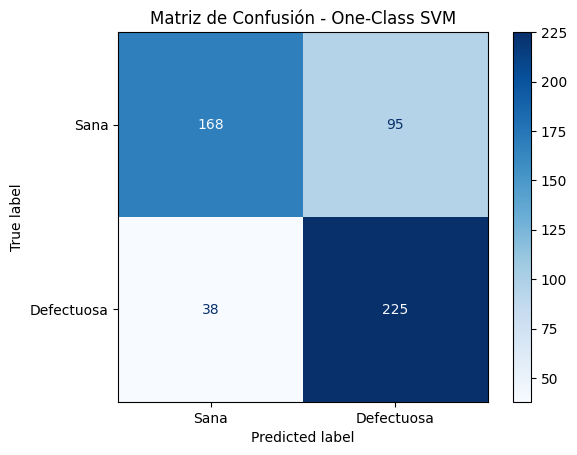

 --------------- Reporte de clasificación - One-Class SVM  --------------- 

              precision    recall  f1-score   support

        Sana       0.82      0.64      0.72       263
  Defectuosa       0.70      0.86      0.77       263

    accuracy                           0.75       526
   macro avg       0.76      0.75      0.74       526
weighted avg       0.76      0.75      0.74       526



In [6]:
# ==========================================
# Evaluación resultados gráficos y métricas de SVM one-class
# ==========================================
cm_svm = confusion_matrix(y_total, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=["Sana", "Defectuosa"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - One-Class SVM")
plt.grid(False)
plt.show()

# Reporte de clasificación
print(" --------------- Reporte de clasificación - One-Class SVM  --------------- \n")
print(classification_report(y_total, y_pred_svm, target_names=["Sana", "Defectuosa"]))

* Entrenamiento con MLP one class

In [7]:
# ==========================================
# 2.2 MLP entrenado como one-class
# ==========================================
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss, accuracy_score

# Creamos etiquetas 1 (defecto) para entrenamiento
y_train = np.ones(X_scaled.shape[0])

# Modelo MLP (pesos aleatorios por defecto)
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200, random_state=42,
                        solver='adam', learning_rate_init=0.001, verbose=True)

# Entrenamiento
mlp_model.fit(X_scaled, y_train)


Iteration 1, loss = 0.46241104
Iteration 2, loss = 0.37041405
Iteration 3, loss = 0.29460577
Iteration 4, loss = 0.23407585
Iteration 5, loss = 0.18497518
Iteration 6, loss = 0.14607351
Iteration 7, loss = 0.11500595
Iteration 8, loss = 0.09111651
Iteration 9, loss = 0.07266674
Iteration 10, loss = 0.05843886
Iteration 11, loss = 0.04752271
Iteration 12, loss = 0.03896471
Iteration 13, loss = 0.03231531
Iteration 14, loss = 0.02699014
Iteration 15, loss = 0.02291458
Iteration 16, loss = 0.01959970
Iteration 17, loss = 0.01705394
Iteration 18, loss = 0.01491861
Iteration 19, loss = 0.01316991
Iteration 20, loss = 0.01179559
Iteration 21, loss = 0.01059434
Iteration 22, loss = 0.00961357
Iteration 23, loss = 0.00877184
Iteration 24, loss = 0.00806857
Iteration 25, loss = 0.00744677
Iteration 26, loss = 0.00691265
Iteration 27, loss = 0.00645766
Iteration 28, loss = 0.00604029
Iteration 29, loss = 0.00567576
Iteration 30, loss = 0.00535370
Iteration 31, loss = 0.00506323
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(64, 32), random_state=42, verbose=True)

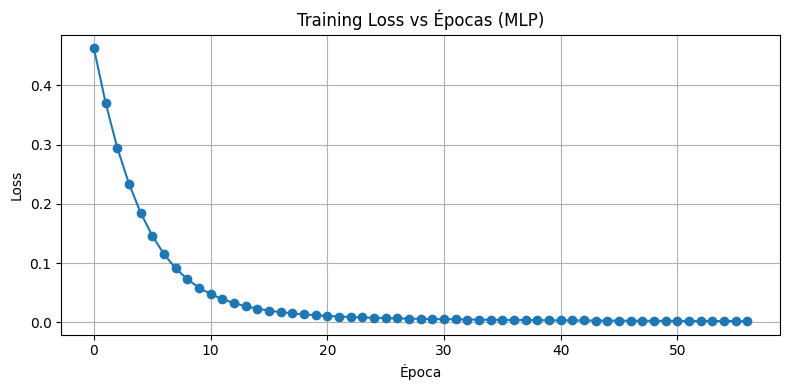

In [8]:
# ==========================================
# Gráfico de training loss
# ==========================================
plt.figure(figsize=(8, 4))
plt.plot(mlp_model.loss_curve_, marker='o')
plt.title("Training Loss vs Épocas (MLP)")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


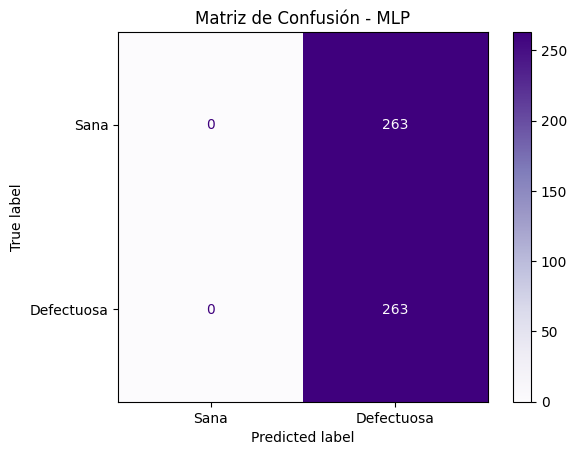

Reporte de clasificación - MLP

              precision    recall  f1-score   support

        Sana       0.00      0.00      0.00       263
  Defectuosa       0.50      1.00      0.67       263

    accuracy                           0.50       526
   macro avg       0.25      0.50      0.33       526
weighted avg       0.25      0.50      0.33       526

Accuracy total: 0.5000
Log Loss total: 3.6723


c:\Users\GMADRO04\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\GMADRO04\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\GMADRO04\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [9]:
# ==========================================
# Evaluación del MLP
# ==========================================
# Predicción sobre el conjunto total
y_pred_mlp = mlp_model.predict(X_total)
y_proba_mlp = mlp_model.predict_proba(X_total)[:, 1]  # probabilidad de clase 1

# Matriz de confusión
cm_mlp = confusion_matrix(y_total, y_pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=["Sana", "Defectuosa"])
disp.plot(cmap="Purples")
plt.title("Matriz de Confusión - MLP")
plt.grid(False)
plt.show()

# Reporte de clasificación
print("Reporte de clasificación - MLP\n")
print(classification_report(y_total, y_pred_mlp, target_names=["Sana", "Defectuosa"]))

# Accuracy
acc = accuracy_score(y_total, y_pred_mlp)
print(f"Accuracy total: {acc:.4f}")

# Log loss con probabilidades
logloss = log_loss(y_total, y_proba_mlp)
print(f"Log Loss total: {logloss:.4f}")


* Entrenamiento con KNN

In [14]:
# ==========================================
# KNN - con clase simulada para entrenamiento
# ==========================================
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier

# Simular clase "sana" (sintética)
X_fake = np.random.normal(loc=0.0, scale=1.0, size=X_scaled.shape)
y_fake = np.zeros(X_scaled.shape[0])  # Clase 0 = sano

# Combinar datos reales + simulados
X_train_knn = np.vstack([X_scaled, X_fake])
y_train_knn = np.concatenate([np.ones(X_scaled.shape[0]), y_fake])
X_train_knn, y_train_knn = shuffle(X_train_knn, y_train_knn, random_state=42)

# Entrenar modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_knn, y_train_knn)

# Evaluar sobre el conjunto real + falso
y_pred_knn = knn_model.predict(X_total)
y_proba_knn = knn_model.predict_proba(X_total)[:, 1]  # Probabilidad de clase 1 = defectuosa



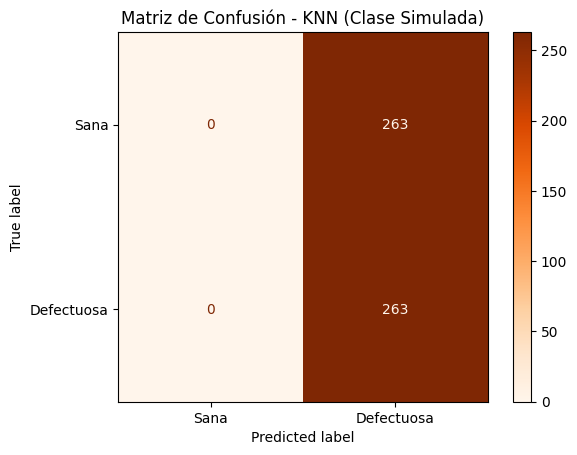

Reporte de clasificación - KNN (Clase simulada)

              precision    recall  f1-score   support

        Sana       0.00      0.00      0.00       263
  Defectuosa       0.50      1.00      0.67       263

    accuracy                           0.50       526
   macro avg       0.25      0.50      0.33       526
weighted avg       0.25      0.50      0.33       526

Accuracy total: 0.5000
Log Loss total: 16.9704


c:\Users\GMADRO04\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\GMADRO04\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\GMADRO04\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [16]:
# ==========================================
# Métricas y visualización
# ==========================================
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusión
cm_knn = confusion_matrix(y_total, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=["Sana", "Defectuosa"])
disp.plot(cmap="Oranges")
plt.title("Matriz de Confusión - KNN (Clase Simulada)")
plt.grid(False)
plt.show()

# Reporte de clasificación
print("Reporte de clasificación - KNN (Clase simulada)\n")
print(classification_report(y_total, y_pred_knn, target_names=["Sana", "Defectuosa"]))

# Accuracy y log loss
acc_knn = accuracy_score(y_total, y_pred_knn)
logloss_knn = log_loss(y_total, y_proba_knn)

print(f"Accuracy total: {acc_knn:.4f}")
print(f"Log Loss total: {logloss_knn:.4f}")


* Comparación modelos


In [17]:
# ==========================================
# Comparación de métricas entre modelos
# ==========================================

resumen_modelos = pd.DataFrame({
    "Modelo": ["One-Class SVM", "MLP", "KNN (Simulado)"],
    "Accuracy": [accuracy_score(y_total, y_pred_svm),
                accuracy_score(y_total, y_pred_mlp),
                accuracy_score(y_total, y_pred_knn)],
    "Log Loss": [np.nan,  # no hay log loss para SVM
                log_loss(y_total, y_proba_mlp),
                log_loss(y_total, y_proba_knn)]
})

resumen_modelos.set_index("Modelo", inplace=True)
resumen_modelos.style.format("{:.4f}").background_gradient(cmap="YlGnBu")


,Accuracy,Log Loss
Modelo,,
One-Class SVM,0.7471,nan
MLP,0.5000,3.6723
KNN (Simulado),0.5000,16.9704


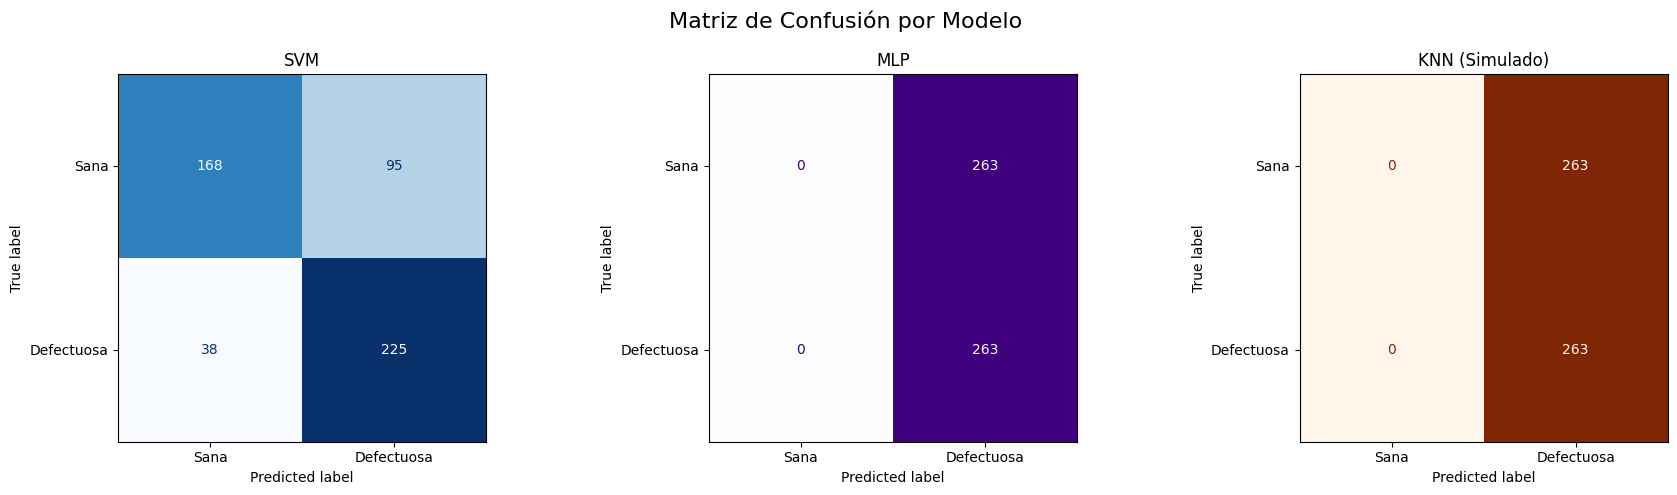

In [18]:
# ==========================================
# Mostrar matrices de confusión comparadas
# ==========================================
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# SVM
ConfusionMatrixDisplay(confusion_matrix(y_total, y_pred_svm),
                        display_labels=["Sana", "Defectuosa"]).plot(ax=axs[0], cmap="Blues", colorbar=False)
axs[0].set_title("SVM")

# MLP
ConfusionMatrixDisplay(confusion_matrix(y_total, y_pred_mlp),
                        display_labels=["Sana", "Defectuosa"]).plot(ax=axs[1], cmap="Purples", colorbar=False)
axs[1].set_title("MLP")

# KNN
ConfusionMatrixDisplay(confusion_matrix(y_total, y_pred_knn),
                        display_labels=["Sana", "Defectuosa"]).plot(ax=axs[2], cmap="Oranges", colorbar=False)
axs[2].set_title("KNN (Simulado)")

plt.suptitle("Matriz de Confusión por Modelo", fontsize=16)
plt.tight_layout()
plt.show()
